# NOTEBOOK FOR DEVELOPING THE EMA STRATEGY

AIM TO HAVE SAME FUNCTIONALITY AS SMA AND RSI STRATEGIES



In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# EMA STRATEGY IS VERY SIMILAR TO SMA STRATEGY EXCEPT EMA GIVES MORE "WEIGHT" TO RECENT PRICES 
## SMA RESPONDS FASTER TO PRICE CHANGES 

THE FORMULA IS AS FOLLOWS: 
- EMA_today = α * Price_today + (1 - α) * EMA_yesterday
- WHERE α = 2 / (n + 1)

## EMA TIME FRAMES
- EMA TIME FRAMES DIFFER FROM THE SMA TIME FRAMES
    - SHORT EMA RANGE: GOOD FOR VOLATILE ASSETS LIKE CRYPTO 
    - LONG EMA RANGE: GOOD FOR SHORT TERM MOMENTUM OR FAST REVERSALS

## MOST CROSS OVER STRATEGIES MIGHT NOT WORK AS MUCH IF A STOCK IS ALWAYS GOING ONE DIRECTION, THE CROSSOVERS HAPPEN LESS OFTEN THEREFORE LESS TRADES

In [ ]:
#Parameters

ticker = "NVDA"
short_ema_period = 10
long_ema_period = 30
take_profit_pct = 0.1
stop_loss_pct = 0.05
years = 5
initial_capital = 1

: 

: 

: 

In [ ]:
# Data download and time
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * years)

df_ema_v1 = yf.download(ticker, start=start_date, end=end_date)

df_ema_v1.columns = df_ema_v1.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_1944\2102379091.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_ema_v1 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


: 

: 

: 

In [ ]:
# Calculate the ema where 'ewm' means exponentially weighted moving 

df_ema_v1['EMA_Short'] = df_ema_v1['Close'].ewm(span=short_ema_period, adjust=False).mean()
df_ema_v1['EMA_Long'] = df_ema_v1['Close'].ewm(span=long_ema_period, adjust=False).mean()

: 

: 

: 

In [ ]:
#signal logic

# Initialize variables
tp_sl_signals = []
in_trade = False
entry_price = 0
trade_returns = []  # ← NEW

for i in range(len(df_ema_v1)):
    close_price = df_ema_v1['Close'].iloc[i]
    ema_short = df_ema_v1['EMA_Short'].iloc[i]
    ema_long = df_ema_v1['EMA_Long'].iloc[i]

    if not in_trade:
        if ema_short > ema_long:
            entry_price = close_price
            in_trade = True
            tp_sl_signals.append(1)
        else:
            tp_sl_signals.append(0)
    else:
        current_return = (close_price - entry_price) / entry_price
        exit_signal = ema_short < ema_long

        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or exit_signal:
            in_trade = False
            trade_returns.append(current_return)  # ← STORE RETURN
            tp_sl_signals.append(0)
        else:
            tp_sl_signals.append(1)

df_ema_v1['TP_SL_Signal'] = tp_sl_signals




: 

: 

: 

In [ ]:
# Convert to Series for easy stats
trade_returns = pd.Series(trade_returns)

# Calculate win rate
total_trades = len(trade_returns)
winning_trades = (trade_returns > 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Win Rate: {win_rate:.2%}")

Total Trades: 42
Winning Trades: 10
Win Rate: 23.81%


: 

: 

: 

In [ ]:
avg_win = trade_returns[trade_returns > 0].mean()
avg_loss = trade_returns[trade_returns < 0].mean()
profit_factor = abs(trade_returns[trade_returns > 0].sum() / trade_returns[trade_returns < 0].sum())


print(f"avg_win: {avg_win}")
print(f"avg_loss: {avg_loss}")
print(f"profit_factor: {profit_factor:.2%}")

avg_win: 0.39697726940023753
avg_loss: -0.04986587015093914
profit_factor: 248.78%


: 

: 

: 

In [ ]:
#calculate returns 

df_ema_v1['Market Return'] = df_ema_v1['Close'].pct_change()
df_ema_v1['Strategy Return'] = df_ema_v1['Market Return'] * df_ema_v1['TP_SL_Signal'].shift(1).fillna(0)


df_ema_v1['Cumulative Market Return'] = (1 + df_ema_v1['Market Return'].fillna(0)).cumprod()
df_ema_v1['Cumulative Strategy Return'] = (1 + df_ema_v1['Strategy Return'].fillna(0)).cumprod()



: 

: 

: 

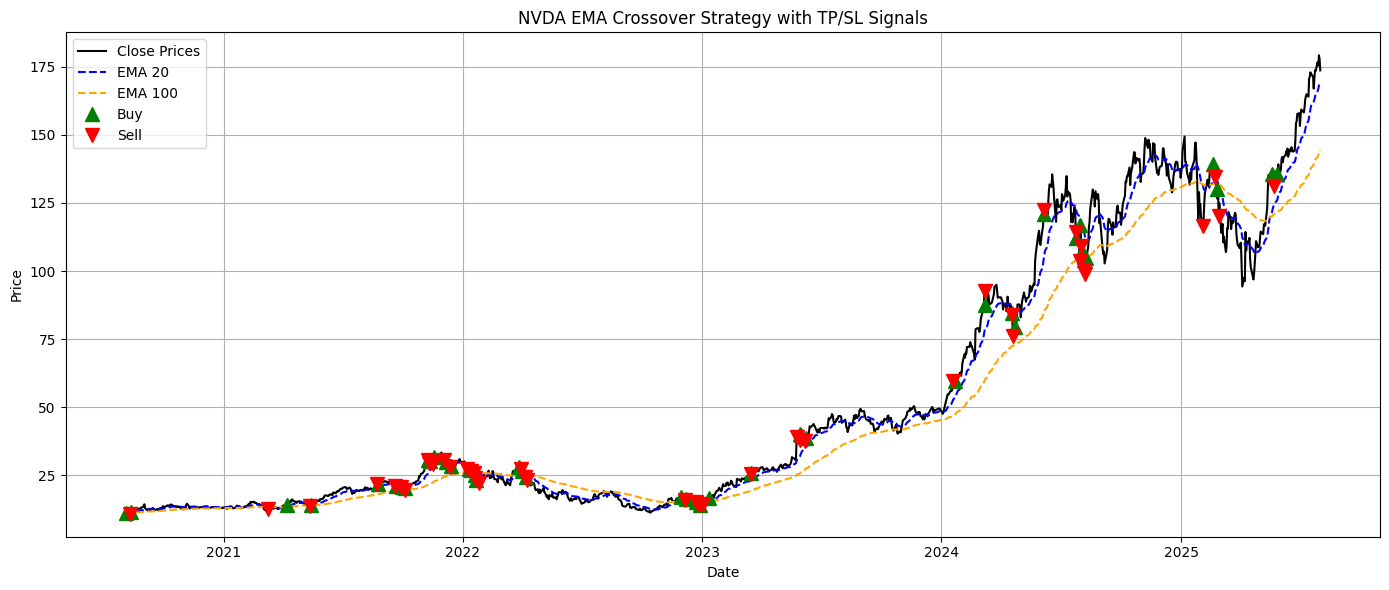

: 

: 

: 

In [ ]:
#plotting buy and sell signals

plt.figure(figsize=(14,6))
plt.plot(df_ema_v1['Close'], label = 'Close Prices', color = 'black')
plt.plot(df_ema_v1['EMA_Short'], label = f'EMA {short_ema_period}', linestyle = '--', color = 'blue')
plt.plot(df_ema_v1['EMA_Long'], label = f'EMA {long_ema_period}', linestyle = '--', color = 'orange')

buy_signals = df_ema_v1[df_ema_v1['TP_SL_Signal'].diff() == 1]
sell_signals = df_ema_v1[df_ema_v1['TP_SL_Signal'].diff() == -1]

plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize = 10, color = 'green', label = 'Buy')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize = 10, color = 'red', label = 'Sell')

plt.title(f'{ticker} EMA Crossover Strategy with TP/SL Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



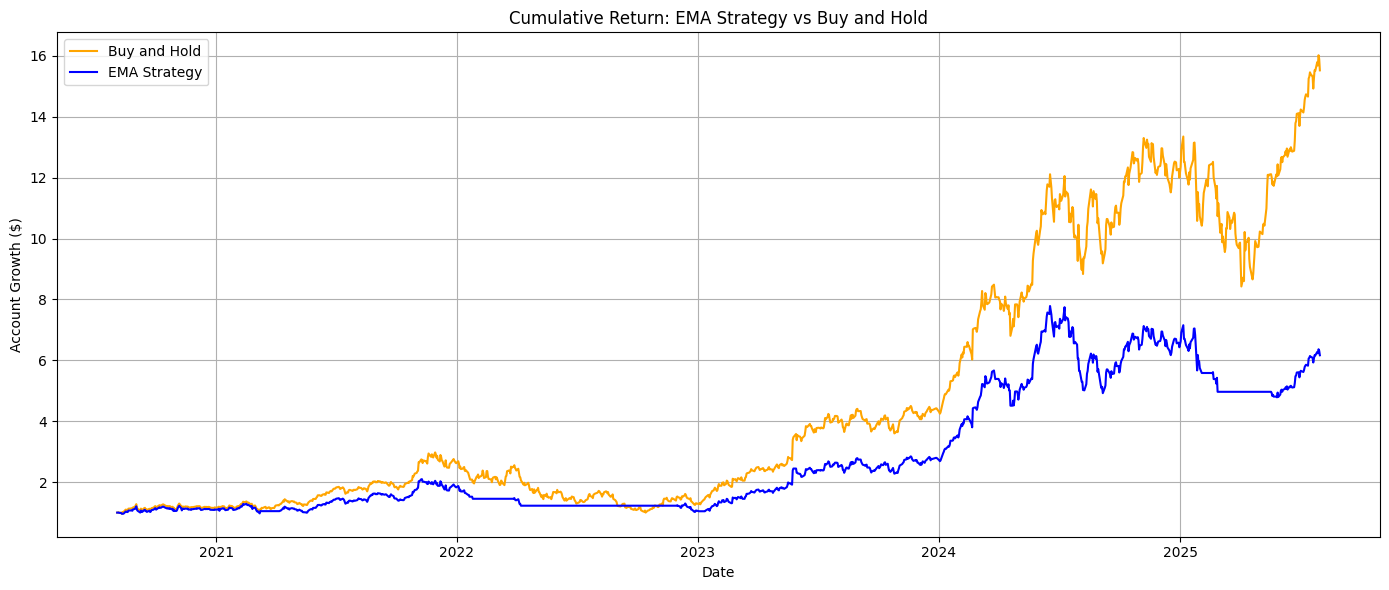

: 

: 

: 

In [ ]:
#plot the Strategy vs Buy and Hold 
plt.figure(figsize=(14,6))
plt.plot(df_ema_v1['Cumulative Market Return'], label = 'Buy and Hold', color = 'orange')
plt.plot(df_ema_v1['Cumulative Strategy Return'], label = 'EMA Strategy', color = 'blue')

plt.title('Cumulative Return: EMA Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Account Growth ($)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

TP_SL_Signal
1    920
0    335
Name: count, dtype: int64


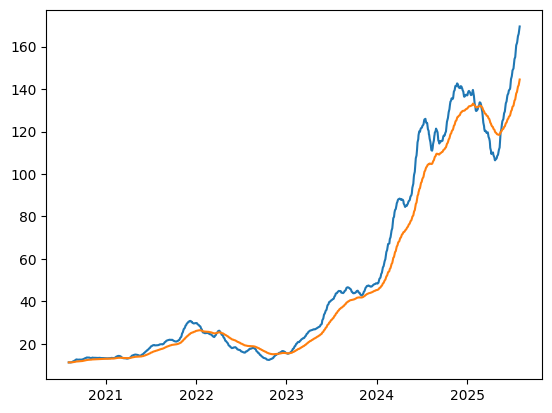

: 

: 

: 

In [ ]:
print(df_ema_v1['TP_SL_Signal'].value_counts())

plt.plot(df_ema_v1['EMA_Short'], label='EMA Short')
plt.plot(df_ema_v1['EMA_Long'], label='EMA Long')


In [ ]:
print("EMA Trades:", df_ema_v1['TP_SL_Signal'].diff().abs().sum() / 2)



EMA Trades: 42.5


: 

: 

: 

## HERE WE HAVE THE SAME TP AND SL LOGIC BUT WITH A LOOP OF TP VALUES THAT WE CAN LOOP THROUGH TO DISPLAY THE OPTIMAL TP LEVELS WE WANT

In [ ]:
# Sweep through different TP values and collect performance metrics

tp_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
results = []

for tp in tp_values:
    # Reuse your full EMA backtest logic here (simplified for clarity)
    df = df_ema_v1.copy()
    tp_sl_signals = []
    in_trade = False
    entry_price = 0
    trade_returns = []

    for i in range(len(df)):
        close_price = df['Close'].iloc[i]
        ema_short = df['EMA_Short'].iloc[i]
        ema_long = df['EMA_Long'].iloc[i]

        if not in_trade:
            if ema_short > ema_long:
                entry_price = close_price
                in_trade = True
                tp_sl_signals.append(1)
            else:
                tp_sl_signals.append(0)
        else:
            current_return = (close_price - entry_price) / entry_price
            exit_signal = ema_short < ema_long

            if current_return >= tp or current_return <= -stop_loss_pct or exit_signal:
                in_trade = False
                trade_returns.append(current_return)
                tp_sl_signals.append(0)
            else:
                tp_sl_signals.append(1)

    df['TP_SL_Signal'] = tp_sl_signals
    df['Market Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Market Return'] * df['TP_SL_Signal'].shift(1).fillna(0)
    df['Cumulative Strategy Return'] = (1 + df['Strategy Return'].fillna(0)).cumprod()

    # Calculate metrics
    trade_returns = pd.Series(trade_returns)
    total_trades = len(trade_returns)
    win_rate = (trade_returns > 0).sum() / total_trades if total_trades > 0 else 0
    avg_win = trade_returns[trade_returns > 0].mean() if total_trades > 0 else 0
    avg_loss = trade_returns[trade_returns < 0].mean() if total_trades > 0 else 0
    profit_factor = abs(trade_returns[trade_returns > 0].sum() / trade_returns[trade_returns < 0].sum()) if (trade_returns < 0).sum() != 0 else np.nan
    final_return = df['Cumulative Strategy Return'].iloc[-1]

    # Store result
    results.append({
        'TP (%)': int(tp * 100),
        'Total Trades': total_trades,
        'Win Rate (%)': round(win_rate * 100, 2),
        'Avg Win (%)': round(avg_win * 100, 2),
        'Avg Loss (%)': round(avg_loss * 100, 2),
        'Profit Factor': round(profit_factor, 2),
        'Final Return (x)': round(final_return, 2)
    })

# Display as DataFrame
results_df = pd.DataFrame(results)
display(results_df)



,TP (%),Total Trades,Win Rate (%),Avg Win (%),Avg Loss (%),Profit Factor,Final Return (x)
0,5,185,48.65,7.30,-4.70,1.47,5.71
1,10,125,40.80,11.88,-4.81,1.70,7.86
2,15,86,32.56,17.12,-4.91,1.68,4.84
3,20,69,30.43,22.54,-5.07,1.94,5.93
4,25,62,29.03,26.48,-4.90,2.21,7.30
5,30,47,29.79,30.41,-4.92,2.62,7.41
6,35,48,27.08,32.48,-5.09,2.37,7.49
7,40,37,27.03,36.82,-5.00,2.73,6.74
8,45,34,29.41,36.11,-5.49,2.74,6.42
9,50,42,23.81,39.70,-4.99,2.49,6.17


: 

: 

: 

: 

: 

: 